In [1]:
pip install onnx

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install onnxruntime

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install opencv-contrib-python 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install azure-cognitiveservices-vision-customvision

Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import sys
import onnxruntime
import onnx
import numpy as np
from PIL import Image, ImageDraw
from object_detection import ObjectDetection
import tempfile

import cv2
import matplotlib.pyplot as plt

In [6]:
ModelFile ='model.onnx'
ImageFile= 'demo.jpg'

In [7]:
with open('labels.txt', 'r') as f:
        labels = [l.strip() for l in f.readlines()]

In [8]:
print(labels)

['mask']


In [9]:
class ONNXRuntimeObjectDetection(ObjectDetection):
    """Object Detection class for ONNX Runtime"""
    def __init__(self, model_filename, labels):
        super(ONNXRuntimeObjectDetection, self).__init__(labels)
        model = onnx.load(model_filename)
        with tempfile.TemporaryDirectory() as dirpath:
            temp = os.path.join(dirpath, os.path.basename(ModelFile))
            model.graph.input[0].type.tensor_type.shape.dim[-1].dim_param = 'dim1'
            model.graph.input[0].type.tensor_type.shape.dim[-2].dim_param = 'dim2'
            onnx.save(model, temp)
            self.session = onnxruntime.InferenceSession(temp)
        self.input_name = self.session.get_inputs()[0].name
        self.is_fp16 = self.session.get_inputs()[0].type == 'tensor(float16)'
        
    def predict(self, preprocessed_image):
        inputs = np.array(preprocessed_image, dtype=np.float32)[np.newaxis,:,:,(2,1,0)] # RGB -> BGR
        inputs = np.ascontiguousarray(np.rollaxis(inputs, 3, 1))

        if self.is_fp16:
            inputs = inputs.astype(np.float16)

        outputs = self.session.run(None, {self.input_name: inputs})
        return np.squeeze(outputs).transpose((1,2,0)).astype(np.float32)

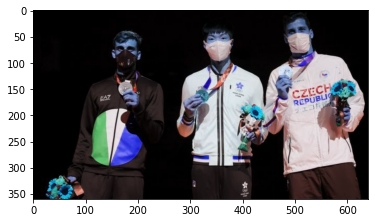

In [10]:
imcv = cv2.imread(ImageFile)
showImage = plt.imshow(imcv)

In [11]:
od_model = ONNXRuntimeObjectDetection(ModelFile, labels)
image = Image.open(ImageFile)
predictions = od_model.predict_image(image)

In [12]:
print(predictions)

[{'probability': 0.89221489, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.75217755, 'top': 0.12399444, 'width': 0.07743412, 'height': 0.11625395}}, {'probability': 0.85932064, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.5178535, 'top': 0.17072415, 'width': 0.0699667, 'height': 0.10216526}}, {'probability': 0.59626549, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.2431834, 'top': 0.24176737, 'width': 0.08025926, 'height': 0.10898855}}, {'probability': 0.12168269, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.7016285, 'top': 0.36658936, 'width': 0.27914408, 'height': 0.34552407}}, {'probability': 0.12047931, 'tagId': 0, 'tagName': 'mask', 'boundingBox': {'left': 0.25173947, 'top': 0.29832625, 'width': 0.07553385, 'height': 0.12839684}}]


In [13]:
height, width, channels = imcv.shape
print(height)
print(width)

360
640


In [14]:
length = len(predictions) 
for i in range(length): 
    left1 = predictions[i]['boundingBox']['left']
    top1 = predictions[i]['boundingBox']['top']
    width1 = predictions[i]['boundingBox']['width']
    height1 = predictions[i]['boundingBox']['height']
    pre = predictions[i]['probability']
    if(pre > 0.5 ):
        left= (int)(left1 * width)
        top = (int)(top1 * height)
        w = (int)(width1 * width + left)
        h = (int)(height1 * height + top)
        cv2.rectangle(imcv,(left,top ),(w,h),(100,0,0),3 )

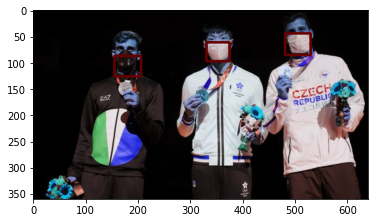

In [15]:
imgplot = plt.imshow(imcv)